In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Libraries and Variables

In [ ]:
# !pip install deeplake
# !pip install fvcore

In [ ]:
import logging
import torch, torchvision
import pickle
import time
import os
import warnings
#import deeplake
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
#from fvcore.nn import FlopCountAnalysis
from torchvision.transforms import v2
from IPython.display import clear_output

from drive.MyDrive.GreenEdge.Pretrained.utils import EarlyExitCustomNet128, CreateDataset, EarlyExitCustomNet64


#Hide warnings
logging.basicConfig(filename='app.log',
    level=logging.CRITICAL,
    force=True,
)

In [ ]:
path = "/content/drive/MyDrive/GreenEdge/Pretrained"
data_path = "/content/drive/MyDrive/GreenEdge/"

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)

Device: cpu


# Dataset Definition

In [ ]:
# Create dataset and dataloader

batches_size = 256


train_dataset = CreateDataset(augmentation = True, train = True, data_path = data_path)
validation_dataset = CreateDataset(augmentation = True, train = False, data_path = data_path)


train_dataloader = DataLoader(train_dataset, batch_size=batches_size,
                        shuffle=True, num_workers=0)

val_dataloader = DataLoader(validation_dataset, batch_size=batches_size,
                        shuffle=False, num_workers=0)

# Display Dataset

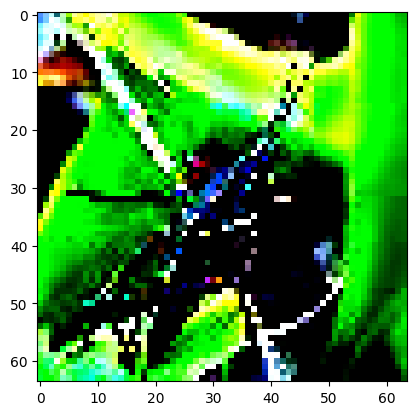

In [ ]:
data = next(iter(train_dataloader))
image = data["images"][1]
figure = plt.figure()
plt.imshow(torch.permute(image,(1,2,0)))

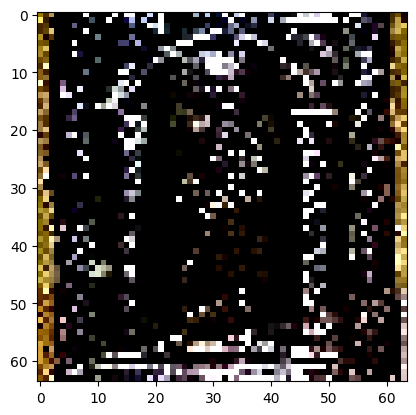

In [ ]:
data = next(iter(val_dataloader))
image = data["images"][1]
figure = plt.figure()
plt.imshow(torch.permute(image,(1,2,0)))

# Model Definition

In [ ]:
weights = "ResNeXt50_32X4D_Weights.IMAGENET1K_V2"

model = EarlyExitCustomNet64(device, weights = weights).to(device)

# Train


In [ ]:
# NB we stopped the training when the model converges
num_epochs = 10

In [ ]:
# Define training optimizer
optimizer = optim.AdamW(model.parameters(), lr= 1e-4, weight_decay= 1e-5)

# Define scheduler
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Define cutmix augmentation
cutmix = v2.CutMix(num_classes=200)

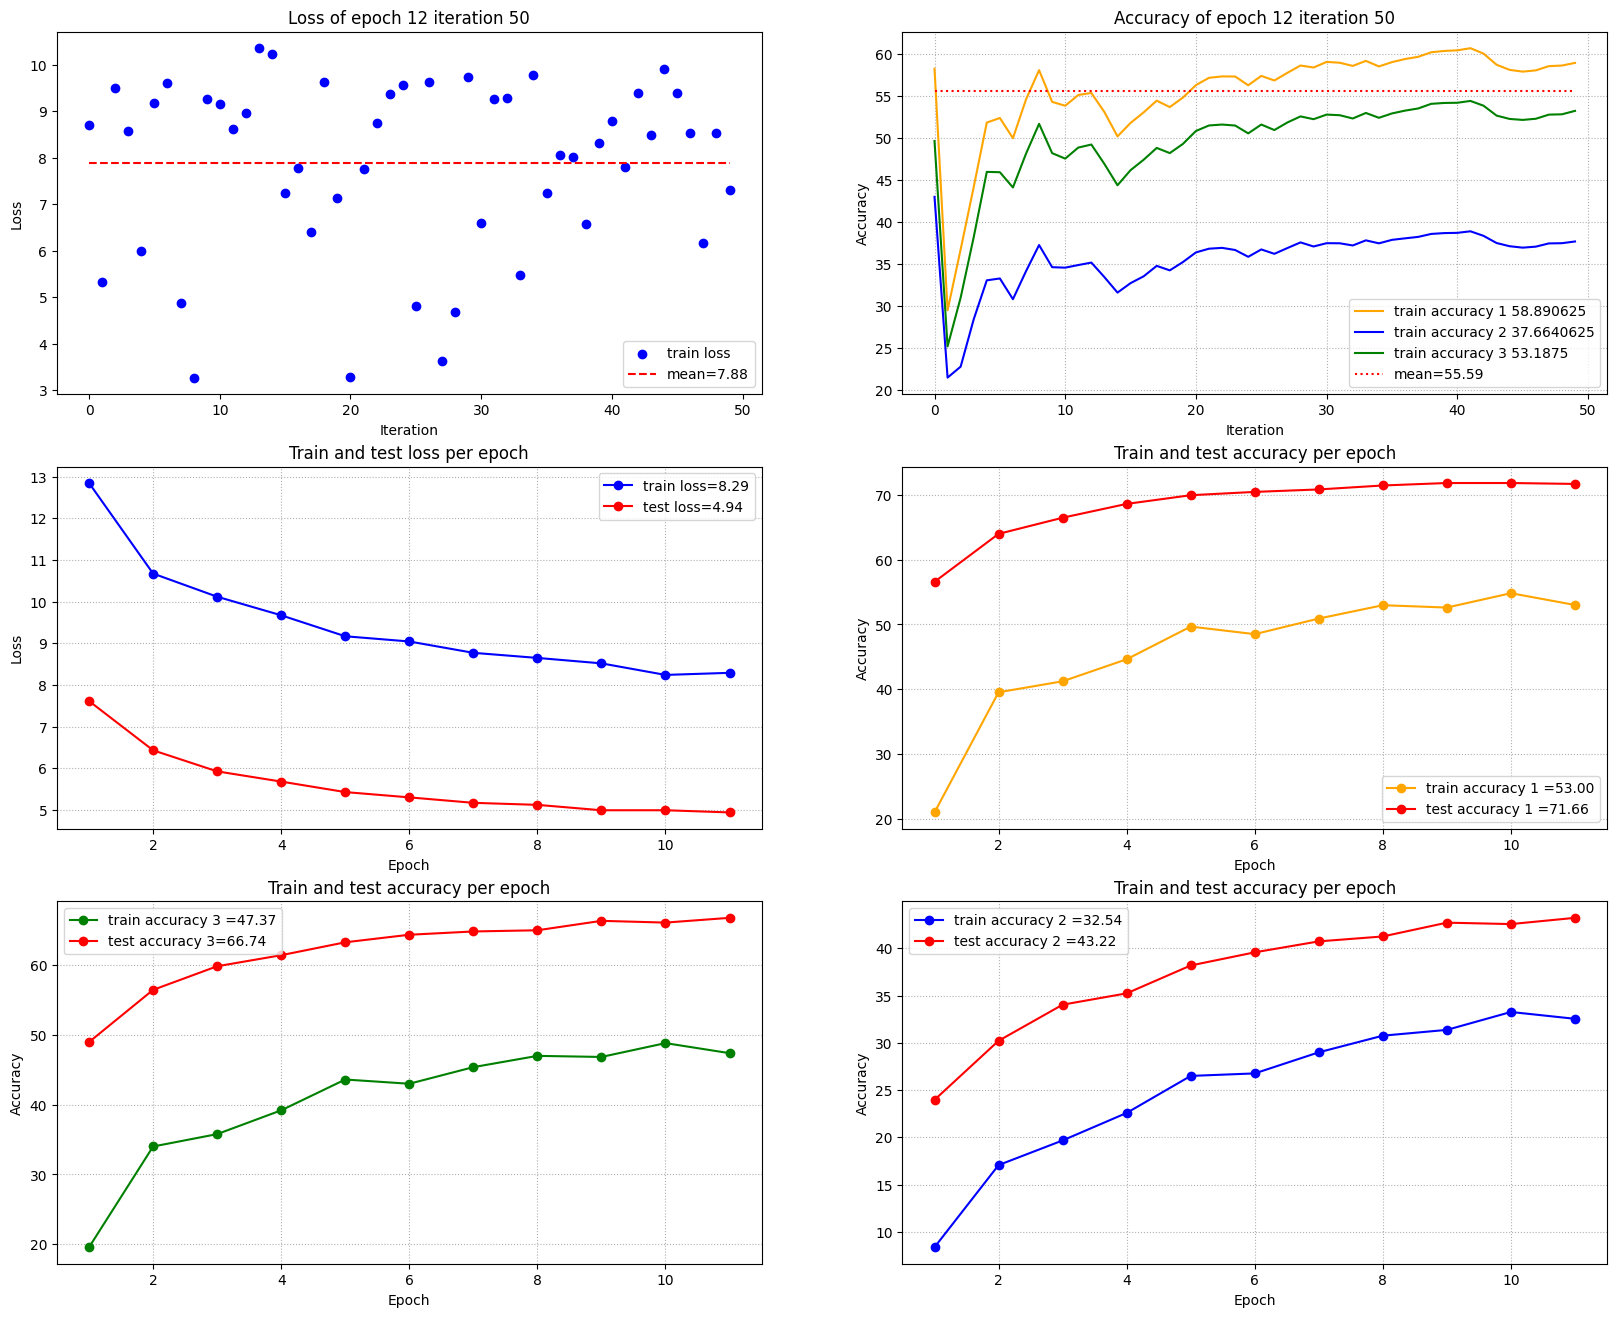

KeyboardInterrupt: 

In [ ]:
iter_record = 50

# Define log lists
train_loss_log = []
train_acc_log1 = []
train_acc_log2 = []
train_acc_log3 = []

test_loss_log = []
test_acc_log1 = []
test_acc_log2 = []
test_acc_log3 = []


for epoch in range(num_epochs):  # loop over the dataset multiple times


    ########################### Save weights ################################

    if (epoch+1) % 5 == 4:
      torch.save(model.state_dict(), path + "/models/resnext50earlycutmix_64_model.torch")
      torch.save(optimizer.state_dict(), path + "/models/resnext50earlycutmix_64_optimizer.torch")

    ########################### Save weights ################################


    ########################### Create lists to record training in real time ################################

    train_loss = []

    train_acc1 = []
    train_acc2 = []
    train_acc3 = []

    record_train_loss = []
    record_train_acc = []
    record_train_acc2 = []
    record_train_acc3 = []

    total1 =  0
    total2 = 0
    total3 = 0

    correct1 = 0
    correct2 = 0
    correct3 = 0


    ########################### Create lists to record training in real time ################################

    start_time = time.time()
    model.train()
    # clear_output()


    ########################### For loop over the dataset ################################
    for i, data in enumerate(train_dataloader):


        ########################### Define input and tranform for cutmix ################################
        inputs = data["images"].float().to(device)
        new_labels = torch.squeeze(data["labels"]).to(device)
        new_labels_hot = new_labels.reshape(len(new_labels))
        inputs, new_labels_hot = cutmix(inputs, new_labels_hot)
        ########################### Define input and tranform for cutmix ################################

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)


        ########################### Predcit to evaluate accuracy of every exit ################################
        _, predicted1 = torch.max(outputs[0].data, 1)
        _, predicted2 = torch.max(outputs[1].data, 1)
        _, predicted3 = torch.max(outputs[2].data, 1)

        # _, indices = torch.topk(output[0].data, 2, 1)
        # c += (indices[:,0]==new_labels_hot.topk(2,1)[:,0]).sum().item() + (indices[:,1]==new_labels_hot.topk(2,1)[:,1]).sum().item()

        correct1 += (predicted1 == new_labels).sum().item()
        correct2 += (predicted2 == new_labels).sum().item()
        correct3 += (predicted3 == new_labels).sum().item()

        total1 += new_labels.size(0)
        total2 += new_labels.size(0)
        total3 += new_labels.size(0)

        acc_batch1 = 100 * correct1 / total1
        acc_batch2 = 100 * correct2 / total2
        acc_batch3 = 100 * correct3 / total3
        ########################### Predcit to evaluate accuracy of every exit ################################


        ########################### Loss evaluation + backward ################################
        loss = loss_fn(outputs[0], new_labels_hot) + loss_fn(outputs[1], new_labels_hot) + loss_fn(outputs[2], new_labels_hot)


        loss.backward()
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        ########################### Loss evaluation + backward ################################


        ########################### Append result for this batch ################################
        train_loss.append(loss_batch)
        train_acc1.append(acc_batch1)
        train_acc2.append(acc_batch2)
        train_acc3.append(acc_batch3)
        ########################### Append result for this batch ################################


        ########################### Plot section ################################
        if i % iter_record == iter_record-1:

            clear_output()

            fig, axs = plt.subplots(3, 2, figsize=(20, 16))

            temp = []
            record_loss = np.mean(train_loss[-iter_record:])
            temp.append(record_loss)
            record_train_loss = record_train_loss + temp*(iter_record)


            temp = []
            record_acc = np.mean(train_acc1[-iter_record:])
            temp.append(record_acc)
            record_train_acc = record_train_acc + temp*(iter_record)


#           Plot data in the first subplot
            axs[0, 0].clear()
            axs[0, 0].scatter(range(len(train_loss)), train_loss, label = "train loss", color = "blue")
            axs[0, 0].plot(range(len(record_train_loss)), record_train_loss, label = f"mean={record_loss:.2f}", color = "red", linestyle = "--")
            axs[0, 0].set_title(f'Loss of epoch {epoch+1} iteration {i+1}')
            axs[0, 0].set_xlabel("Iteration")
            axs[0, 0].set_ylabel("Loss")
            axs[0, 0].legend()


#           Plot data in the second subplot
            axs[0, 1].clear()
            axs[0, 1].plot(range(len(train_acc1)), train_acc1, label = f"train accuracy 1 {train_acc1[-1]}", color = "orange")
            axs[0, 1].plot(range(len(train_acc2)), train_acc2, label = f"train accuracy 2 {train_acc2[-1]}", color = "blue")
            axs[0, 1].plot(range(len(train_acc3)), train_acc3, label = f"train accuracy 3 {train_acc3[-1]}", color = "green")
            axs[0, 1].plot(range(len(record_train_acc)), record_train_acc, label = f"mean={record_acc:.2f}", color = "red", linestyle = ":")
            axs[0, 1].set_title(f'Accuracy of epoch {epoch+1} iteration {i+1}')
            axs[0, 1].set_xlabel("Iteration")
            axs[0, 1].set_ylabel("Accuracy")
            axs[0, 1].grid(True, linestyle=":")
            axs[0, 1].legend()

            if epoch != 0:
              # Plot data in the third subplot
              axs[1, 0].clear()
              axs[1, 0].plot(range(1,len(train_loss_log)+1), train_loss_log, label = f"train loss={train_loss_log[-1]:.2f}", color = "blue", marker="o")
              axs[1, 0].plot(range(1,len(test_loss_log)+1), test_loss_log, label = f"test loss={test_loss_log[-1]:.2f}", color = "red", marker="o")
              axs[1, 0].set_title('Train and test loss per epoch')
              axs[1, 0].set_xlabel("Epoch")
              axs[1, 0].set_ylabel("Loss")
              axs[1, 0].grid(True, linestyle=":")
              axs[1, 0].legend()


              # Plot data in the fourth subplot
              axs[1, 1].clear()
              axs[1, 1].plot(range(1,len(train_acc_log1)+1), train_acc_log1, label = f"train accuracy 1 ={train_acc_log1[-1]:.2f}", color = "orange", marker="o")
              axs[1, 1].plot(range(1,len(test_acc_log1)+1),test_acc_log1, label = f"test accuracy 1 ={test_acc_log1[-1]:.2f}", color = "red", marker="o")
              axs[1, 1].set_title('Train and test accuracy per epoch')
              axs[1, 1].set_xlabel("Epoch")
              axs[1, 1].set_ylabel("Accuracy")
              axs[1, 1].grid(True, linestyle=":")
              axs[1, 1].legend()

              axs[2, 1].plot(range(1,len(train_acc_log2)+1), train_acc_log2, label = f"train accuracy 2 ={train_acc_log2[-1]:.2f}", color = "blue", marker="o")
              axs[2, 1].plot(range(1,len(test_acc_log2)+1),test_acc_log2, label = f"test accuracy 2 ={test_acc_log2[-1]:.2f}", color = "red", marker="o")
              axs[2, 1].set_title('Train and test accuracy per epoch')
              axs[2, 1].set_xlabel("Epoch")
              axs[2, 1].set_ylabel("Accuracy")
              axs[2, 1].grid(True, linestyle=":")
              axs[2, 1].legend()

              axs[2, 0].plot(range(1,len(train_acc_log3)+1), train_acc_log3, label = f"train accuracy 3 ={train_acc_log3[-1]:.2f}", color = "green", marker="o")
              axs[2, 0].plot(range(1,len(test_acc_log3)+1), test_acc_log3, label = f"test accuracy 3={test_acc_log3[-1]:.2f}", color = "red", marker="o")
              axs[2, 0].set_title('Train and test accuracy per epoch')
              axs[2, 0].set_xlabel("Epoch")
              axs[2, 0].set_ylabel("Accuracy")
              axs[2, 0].grid(True, linestyle=":")
              axs[2, 0].legend()

            plt.show()
          ########################### Plot section ################################


    ########################### Append section for every exit ################################
    # Save average train loss and train accuracy
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)

    #train_acc = np.mean(train_acc)
    train_acc_log1.append(train_acc1[-1])
    train_acc_log2.append(train_acc2[-1])
    train_acc_log3.append(train_acc3[-1])
    ########################### Append section for every exit ################################



    end_time = time.time()
    print(f"Epoch time: {(end_time-start_time):.2f}")



    ########################### Validation section ################################

    total1 =  0
    correct1 = 0
    total2 =  0
    correct2 = 0
    total3 =  0
    correct3 = 0

    test_loss = []

    model.train() # here we validate without considering the eaarly exit entropy but just the accuracy of the three exits.
    ########################### Validation section ################################


    ########################### For loop over the validation dataset ################################
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):


            inputs = data['images']
            inputs = inputs.to(device)


            labels = torch.squeeze(data['labels'])
#             labels = torch.LongTensor([labels_map[label.item()] for label in labels])
            labels = labels.to(device)

            outputs = model(inputs.float())

            _, predicted1 = torch.max(outputs[0].data, 1)
            _, predicted2 = torch.max(outputs[1].data, 1)
            _, predicted3 = torch.max(outputs[2].data, 1)

            correct1 += (predicted1 == labels).sum().item()
            correct2 += (predicted2 == labels).sum().item()
            correct3 += (predicted3 == labels).sum().item()

            total1 += labels.size(0)
            total2 += labels.size(0)
            total3 += labels.size(0)

            acc_batch1 = 100 * correct1 / total1
            acc_batch2 = 100 * correct2 / total2
            acc_batch3 = 100 * correct3 / total3


            loss = loss_fn(outputs[0], labels) + loss_fn(outputs[1], labels) + loss_fn(outputs[2], labels)

            loss_batch = loss.detach().cpu().numpy()

            test_loss.append(loss_batch)



        test_acc1 = 100 * correct1 / (total1)
        test_acc2 = 100 * correct2 / (total2)
        test_acc3 = 100 * correct3 / (total3)

        test_acc_log1.append(test_acc1)
        test_acc_log2.append(test_acc2)
        test_acc_log3.append(test_acc3)
      ########################### For loop over the validation dataset ################################




    test_loss = np.mean(test_loss)
    test_loss_log.append(test_loss)
    #scheduler.step(test_loss)
    print(f"[Learning rate]: {scheduler.get_last_lr()}")

In [ ]:
torch.save(model.state_dict(),path+"/models/resnext50earlycutmix_64_model.torch")
torch.save(optimizer.state_dict(),path+"/models/resnext50earlycutmix_64_optimizer.torch")